In [ ]:
using Pkg
# environmentName wird an einigen Stellen im Notebook verwendet
environmentName = "02-networks"
Pkg.activate(joinpath(dirname(pwd()), "Notebooks", "conf", environmentName))
Pkg.instantiate();

  Activating project at `/media/johannes/DATA/Syncthing/Programmierung/MathData-SoSe22/Notebooks/conf/02-networks`


# Netzwerkanalyse

Diese Notebook geht wie folgt vor:
1. Netzwerk-Daten laden
2. Adjazenzmatrix $A$ erstellen
3. Graph $G$ aus $A$ erstellen (sparse, ohne loops) und plotten
5. Laplace Matrix $L$ berechnen
6. Eigenwerte $\lambda_i$ von $L$ berechnen
7. Größte Zusammenhangskomponente $H$ von $G$ finden und plotten
8. Spektrum von $H$ berechnen und plotten
9. Clustering von $H$ anhand des Eigenvektors $f_H$ zu Eigenwert $\lambda_H$
9. Clustering von $H$ anhand des Eigenvektors $f_{|V(H)|-1}$ zu Eigenwert $\lambda_{|V(H)|-1}$

# Netzwerk-Daten laden
Die Daten für dieses Notebook liegen in "data/02-networks/graph.json". Diese [JSON-Datei](https://en.wikipedia.org/wiki/JSON) enthält ein Array von Einträgen mit Attributen "name" und "links". "links" widerum ist ein Array von Strings. Jeder Einträg repräsentiert eine [englischsprachige Wikipedia Seite](https://en.wikipedia.org/wiki/Main_Page) deren Name/Titel "data" oder "science" enthält (nicht case sensitive). Die Seiten (identifiziert bei "name") sind die Knoten unseres Graphen und die "links" sind gerichtete Kanten im Graphen. Im Folgenden werden wir allerdings die "Richtung" der Kanten außer acht lassen und zwei Knoten werden miteinander durch eine Kante verbunden, wenn eine gerichtete Kante zwischen  diesen existiert.

## Beispiel-Daten (ausgedacht)
```JSON
[
    {
        "name": "Data_science",
        "links": [
            "Data",
            "Science"
        ]
    },
    {
        "name": "Data",
        "links": [
            "Data_science",
            "Science"
        ]
    },
    {
        "name": "Science",
        "links": [
            "Data_science",
            "Database"
        ]
    },
    {
        "name": "Database",
        "links": [
            "Data"
        ]
    }
]
```

## Beispiel Graph
Graph $G = (V, E)$ mit

$V = \{\text{Data\_science}, \text{Data}, \text{Science}, \text{Database}\}$ und

$E = \{\{\text{Data\_science}, \text{Data}\}, \{\text{Data\_science}, \text{Science}\}, \{\text{Data}, \text{Science}\}, \{\text{Database}, \text{Science}\}, \{\text{Data}, \text{Database}\}\}$.

Der Einfachheit halber können die Knoten $V$ auch einfach durchnummiert.

In [44]:
using JSON3

data = JSON3.read(read("data/" * environmentName * "/graph.json"))
println("typeof(data) = " * string(typeof(data)))
println("Anzahl Einträge im Array = " * string(length(data)))
# erste 10 Einträge anzeigen
println(first(data, 10))

typeof(data) = JSON3.Array{JSON3.Object, Vector{UInt8}, Vector{UInt64}}
Anzahl Einträge im Array = 1351
JSON3.Object[{
    "name": "Data_science",
   "links": [
              "Data",
              "Metadata"
            ]
}, {
    "name": "Computer_science",
   "links": [
              "Database",
              "Science"
            ]
}, {
    "name": "Information_science",
   "links": [
              "Data",
              "Database",
              "Metadata"
            ]
}, {
    "name": "Big_data",
   "links": [
              "Datafication",
              "Data",
              "Data-mining",
              "Database",
              "E-Science",
              "Metadata",
              "Teradata"
            ]
}, {
    "name": "Computational_science",
   "links": [
              "Science",
              "Sciences"
            ]
}, {
    "name": "Data_acquisition",
   "links": [
              "Data",
              "Metadata"
            ]
}, {
    "name": "Data_cleansing",
   "links": [

# Adjazenzmatrix $A$ erstellen

In [45]:
using SparseArrays

n = length(data)
V = 1:n
# diese Map übersetzt Seitennamen zu Knotennummern
name_map = Dict()
A = zeros(Int, n, n)
E = []

# Seitennamen mit Knotennummern assoziieren
for i = V
    name_map[data[i].name] = i
end

for i = V
    page = data[i]
    for j = 1:length(page.links)
        linked_page = page.links[j]
        # nur links verwenden, für die Knoten existieren!
        if haskey(name_map, linked_page)
            # Symmetrie beachten!
            A[i, name_map[linked_page]] = A[name_map[linked_page], i] = 1
        end
    end
end

A = sparse(A)
A

1351×1351 SparseMatrixCSC{Int64, Int64} with 3756 stored entries:
⎡⢺⠒⣿⠛⠻⠒⡖⠲⡒⠒⠒⠒⠂⠂⠐⠐⠒⠒⠒⠒⠒⠒⠒⠐⠒⠒⠒⠐⠒⠒⠐⠒⠒⠐⠒⠐⠐⠀⠀⠀⎤
⎢⣿⠛⣿⣿⣿⡿⠿⢿⢛⢻⡽⣽⣿⣯⣽⠿⠛⠻⠿⡟⡿⣿⠿⣿⡶⡿⠟⠿⠿⠿⠟⡛⢿⣿⢿⡬⠾⠾⢯⠾⎥
⎢⢻⠂⣿⡿⢡⠖⠷⠍⠉⠊⠕⠦⠧⠤⠤⠵⠃⠋⠭⠤⠨⠴⠄⣩⠽⠡⡦⢔⢦⢩⠬⡠⠤⠴⠤⠤⠠⠥⠭⠤⎥
⎢⢸⡉⣿⣇⡝⠇⣁⠘⠀⢈⠉⠈⠀⠀⠀⡀⢀⣆⠀⣀⠀⠀⠀⠀⠀⠀⢀⠀⢈⠀⠂⡀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢸⠈⣿⣐⡣⠀⡀⢀⠀⢀⠀⣀⡀⠀⠀⢀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⢀⠀⢀⠀⠀⡀⠀⠀⠀⠀⡀⠀⠀⠀⎥
⎢⢸⠀⣗⣯⠱⡅⡃⠀⠀⢠⡏⣭⡭⣤⣠⣠⠀⠀⠀⠀⣄⢤⣀⠄⠀⠠⠁⠀⠀⠀⡀⠀⢠⣥⣣⡀⠀⠀⢤⠄⎥
⎢⠨⠀⡿⣿⠉⡇⠀⠀⠀⠈⠃⣯⡟⠉⠈⠀⠀⠄⠀⠀⠁⠉⠉⠀⠀⠀⠀⠁⠀⠀⠀⠀⠈⠍⠁⠀⠀⠁⠈⠀⎥
⎢⢐⠀⣷⡟⢄⡇⠀⠠⠀⢀⠀⣺⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢸⠀⣿⡀⡭⠀⠠⢴⠀⠀⠀⠀⠀⠄⠀⠀⠤⡧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢸⠀⣿⠧⠃⡇⠀⢠⠀⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢸⠀⣿⣯⢂⡆⠀⠀⠀⠀⠀⣝⡅⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠄⠀⠀⡀⠠⡀⠀⠀⠠⠀⠀⠀⎥
⎢⢘⠀⣿⣧⡄⣡⠀⠀⠀⠀⠀⠜⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠁⠀⠀⠀⠀⠀⠀⎥
⎢⢸⠀⣼⡯⠗⡃⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠠⠀⠈⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠁⠀⠠⠀⠀⠀⠠⠀⎥
⎢⢘⠀⣿⡅⢈⢏⠀⠐⠀⠐⠁⠀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢸⠀⣿⡇⡌⣓⠂⠐⠀⠐⠀⠀⠀⠀⠀⠀⠀⠄⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢰⠀⣿⠡⠂⡣⠈⠠⠀⠠⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢘⠀⣿⣷⢀⡇⠀⠀⠀⠀⠄⣶⡆⠄⠀⠐⠀⠀⠀⠀⠀⠢⠔⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢘⠀⡛⡷⠀⡇⠀⠀⠀⠀⠉⠺⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⎥
⎢⠐⠀⣺⡇⠄⡆⠀⠀⠀⠈⠀⠀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠄⠀⠀⠀⠀⠀⎥
⎣⠀⠀⣫⡗⠃⡇⠀⠀⠀⠀⠀⠗⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦

Der Graph wird durch die Adjazenzmatrix $A$ gegeben.

In [46]:
using Graphs

G = Graphs.Graph(A)

{1351, 1878} undirected simple Int64 graph

Wir entfernen außerdem die Knoten mit Grad 0 aus dem Graphen.

In [47]:
d = Graphs.degree(G)
not0 = findall(d .!= 0)
V = V[not0]
A = A[not0,not0]
d = d[not0]
G = Graphs.Graph(A)

{1196, 1878} undirected simple Int64 graph

Und nun visualisieren wir den Graphen, der durch die Adjazenzmatrix gegeben wird.

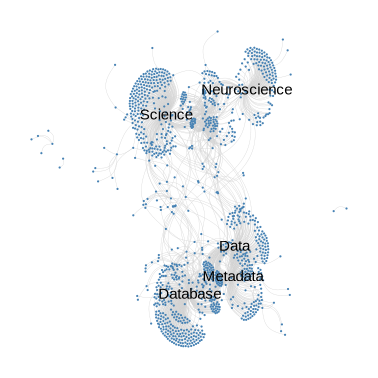

In [48]:
using GraphPlot, Plots, Compose, Cairo, Fontconfig

c = sortperm(d, rev = true)[1:5]
labels = ["" for v in V]
node_names = [data[v].name for v in V]
labels[c] = node_names[c]
layout = spring_layout(G; C=5)
P1 = gplot(G, layout...;
        linetype="curve", 
        nodelabel=labels,
        nodelabeldist=2,
        nodefillc = colorant"steelblue"
)
draw(PNG("img/" * environmentName * "/graph_visualisation.png", 16cm, 16cm), P1)
P1

---
---
# Die Laplace Matrix

Wir berechnen die Laplace Matrix `L` von `G`.

In [49]:
n = length(d)
L = zeros(n, n)
for i in 1:n
    for j in 1:n
        if i == j
            L[i,j] = 1
        elseif A[i,j] == 1
            L[i,j] = - 1 / sqrt(d[i] * d[j])
        end
    end
end
L

1196×1196 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱       ⋮                        ⋮
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

Die Eigenwerte von `L` werden dann wie folgt berechnet:

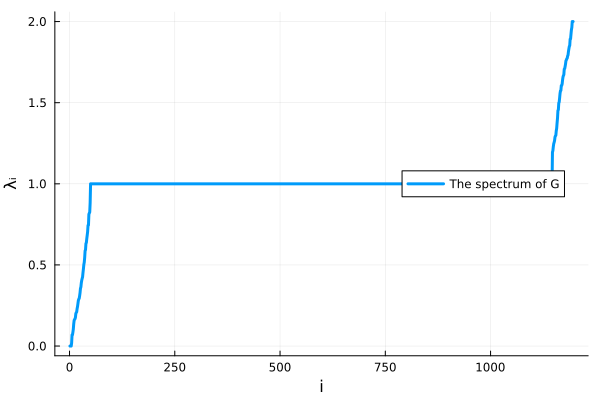

In [50]:
using LinearAlgebra

E = eigen(L)
λ = E.values
P2 = plot(λ, label = "The spectrum of G", 
             legend = 0,
             linewidth = 3,
             xlab = "i",
             ylab = "λᵢ")
savefig(P2, "img/" * environmentName * "/spectrum_of_G.png")
P2

Die Anzahl der Komponenten ist gleich der Dimension des Kerns von `L`.

In [51]:
n_components = count(λ .< 1e-14)

4

In [52]:
C = connected_components(G)

4-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196]
 [220, 933]
 [306, 513, 886, 887, 1104]
 [899, 900]

In [53]:
sum(λ), n

(1195.9999999999998, 1196)

---
# Analyse einer Komponente

Wir analyieren nun die größte Zusammenhangskomponente `H` von `G`

Wir berechnen auch die Zusammenhangskomponenten

In [54]:
k = findmax(length.(C))
I = C[k[2]];
H = Graph(A[I, I])

{1187, 1872} undirected simple Int64 graph

Wir plotten zunächst diese Komponente.

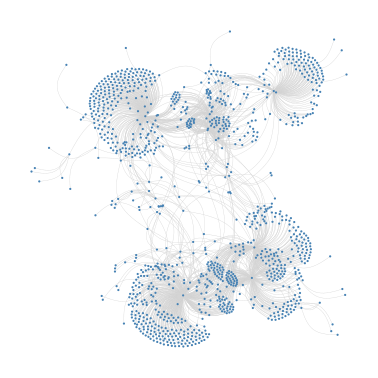

In [55]:
layout_H = (layout[1][I], layout[2][I])
P3 = gplot(H, layout_H...;
        linetype="curve", 
        nodelabeldist=2,
        nodefillc = colorant"steelblue"
)
draw(PNG("img/" * environmentName * "/graph_H_visualisation.png", 16cm, 16cm), P3)
P3

Jetzt berechnen wir das Spektrum von `H`.

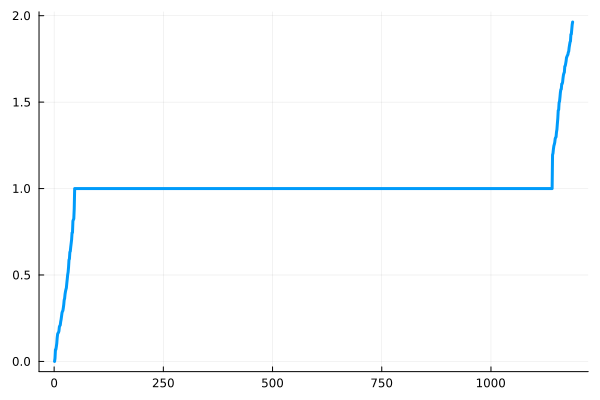

In [56]:
L_H = L[I,I]
E_H = eigen(L_H)
λ_H = E_H.values
P4 = plot(λ_H, legend = false, linewidth = 3)
savefig(P4, "img/" * environmentName * "/spectrum_of_H.png")
P4

Sei nun `w` Eigenvektor von $\lambda_G$. 

Wir plotten die Knoten je nach Vorzeichen von `w` rot oder blau. Wir färben gelb, falls der Eintrag von `w` Null ist.

Dies zeigt uns Komponenten von `H`, die "fast" zusammenhängend sind.

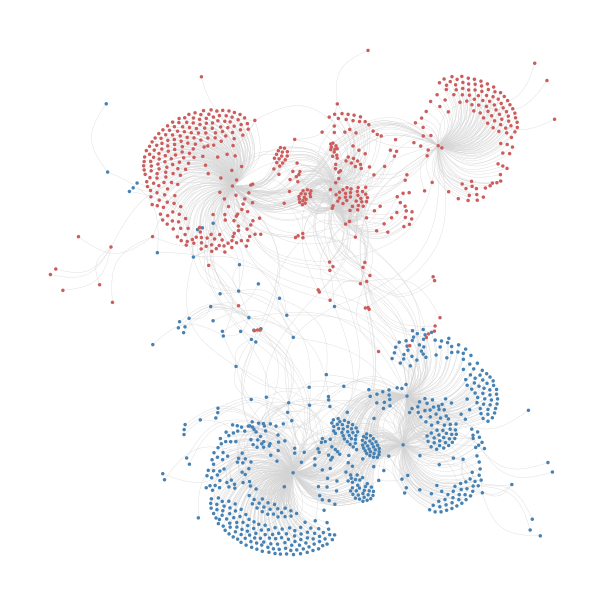

In [57]:
using Images, IJulia

w = E_H.vectors[:,2]
cols = []
for wᵢ in w
    if abs(wᵢ) > 1e-12 
        if wᵢ < 0
            push!(cols, colorant"steelblue")
        else
            push!(cols, colorant"indianred")
        end
    else
        push!(cols, colorant"orange")
    end
end
layout= x -> spring_layout(x; C=5)
P5 = gplot(H, layout_H...;
        linetype="curve", 
        nodelabeldist=2,
        nodefillc = cols
)
# wir speichern das Bild und plotten dann das nachgeladene Bild,
# weil jupyter teilweise Probleme damit hat gefärbte Graphen anzuzeigen, die viele Knoten enthalten
imagePath = "img/" * environmentName * "/clustering_of_H_by_smallest_lambda.png"
draw(PNG(imagePath, 16cm, 16cm), P5)
IJulia.display(load(imagePath))

Die Labels der zwei Cluster sind wie folgt:

In [58]:
[entry.name for entry in data[I][w .> 0]]

550-element Vector{String}:
 "Computer_science"
 "Computational_science"
 "Formal_science"
 "Natural_science"
 "Political_science"
 "American_Academy_of_Arts_and_Sciences"
 "Bachelor_of_Science"
 "Constructivism_(philosophy_of_science)"
 "Pseudoscience"
 "Philosophy_of_computer_science"
 ⋮
 "Repression_of_science_in_the_Soviet_Union"
 "The_Republican_War_on_Science"
 "Index_of_branches_of_science"
 "1807_in_science"
 "1665_in_science"
 "1909_in_science"
 "1660_in_science"
 "Science_Bulletin"
 "Science_in_the_Soul"

In [59]:
[entry.name for entry in data[I][w .< 0]]

637-element Vector{String}:
 "Data_science"
 "Information_science"
 "Big_data"
 "Data_acquisition"
 "Data_cleansing"
 "Data_augmentation"
 "Data_anonymization"
 "Data_archaeology"
 "Data"
 "Data_analysis"
 ⋮
 "Science_Friday"
 "Science.gov"
 "International_Union_of_Anthropological_and_Ethnological_Sciences"
 "Idealization_(philosophy_of_science)"
 "Energy_Science_and_Technology_Database"
 "Source_Code_in_Database"
 "Master_in_Data_Science"
 "Berkeley_Initiative_for_Transparency_in_the_Social_Sciences"
 "Science.tv"

Jetzt färben wir ähnlich für den größten Eigenwert.

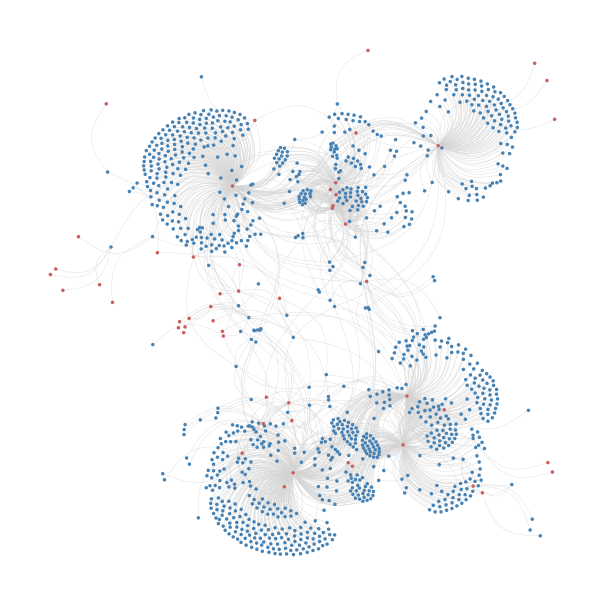

In [60]:
using IJulia, Images

u = E_H.vectors[:,end]
cols = []
for uᵢ in u
    if abs(uᵢ) > 1e-12 
        if uᵢ < 0
            push!(cols, colorant"steelblue")
        else
            push!(cols, colorant"indianred")
        end
    else
        push!(cols, colorant"orange")
    end
end
P6 = gplot(H, layout_H...;
        linetype="curve",
        nodefillc = cols
)
# wir speichern das Bild und plotten dann das nachgeladene Bild,
# weil jupyter teilweise Probleme damit hat gefärbte Graphen anzuzeigen, die viele Knoten enthalten
imagePath = "img/" * environmentName * "/clustering_of_H_by_largest_lambda.png"
draw(PNG(imagePath, 16cm, 16cm), P6)
IJulia.display(load(imagePath))

In [61]:
[entry.name for entry in data[I][u .> 1e-12]]

53-element Vector{String}:
 "Data"
 "Metadata"
 "Pseudoscience"
 "Database"
 "Earth_science"
 "Science"
 "Human_science"
 "EScience"
 "Metascience"
 "Datafication"
 ⋮
 "Data-informed_decision-making"
 "Machine-generated_data"
 "Euglossa_cordata"
 "Data_(moth)"
 "Science_for_the_People"
 "Schema-agnostic_databases"
 "Collegiate_School_of_Medicine_and_Bioscience"
 "Prize_of_the_Foundation_for_Polish_Science"
 "TMS_(entertainment_data)"

In [62]:
[entry.name for entry in data[I][u .< 1e-12]]

1134-element Vector{String}:
 "Data_science"
 "Computer_science"
 "Information_science"
 "Big_data"
 "Computational_science"
 "Data_acquisition"
 "Data_cleansing"
 "Data_augmentation"
 "Data_anonymization"
 "Data_archaeology"
 ⋮
 "The_Republican_War_on_Science"
 "Index_of_branches_of_science"
 "1807_in_science"
 "1665_in_science"
 "1909_in_science"
 "1660_in_science"
 "Science_Bulletin"
 "Science.tv"
 "Science_in_the_Soul"